In [1]:
import os
import re
import sys

import h5py
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks')


In [2]:
#Load westminster scripts (gtex coefficient helper functions)

sys.path.append('/home/drk/code/westminster/src/westminster/scripts/')
from westminster_gtex_coef import read_eqtl
from westminster_gtex_coef import read_scores as read_borzoi


In [3]:
#Define folders with SNP predictions

gtex_vcf_dir = '/home/drk/seqnn/data/gtex_fine/susie_pip90'
borzoi_dir = '/home/drk/seqnn/data/models/v2'
borzoi_gtex_dir = '%s/ensemble/gtexu' % borzoi_dir


In [4]:
#Load SNP filter lists (train or test windows from hg38)

filter_file_train = '/home/jlinder/analysis/bench_apa/gtex_susie_pip90_f3c0_train.txt'
filter_file_test = '/home/jlinder/analysis/bench_apa/gtex_susie_pip90_f3c0_test.txt'

#Filter lists
snp_list_train = pd.read_csv(filter_file_train, sep='\t', names=['variant'])['variant'].values.tolist()
snp_list_test = pd.read_csv(filter_file_test, sep='\t', names=['variant'])['variant'].values.tolist()


In [5]:
# Enformer supplement
# tissue_keywords = {
#     'Adipose_Subcutaneous': 'adipose',
#     'Esophagus_Mucosa': 'esophagus',
#     'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
#     'Testis': 'testis',
#     'Thyroid': 'thyroid',
#     'Whole_Blood': 'blood',
# }
# Extended set
tissue_keywords = {
      'Adipose_Subcutaneous': 'adipose',
      'Breast_Mammary_Tissue': 'breast',
      'Colon_Transverse': 'colon',
      'Esophagus_Mucosa': 'esophagus',
      'Liver': 'liver',
      'Lung': 'lung',
      'Muscle_Skeletal': 'muscle',
      'Ovary': 'ovary',
      'Pancreas': 'pancreas',
      'Pituitary': 'pituitary',
      'Prostate': 'prostate',
      'Skin_Not_Sun_Exposed_Suprapubic': 'skin',
      'Spleen': 'spleen',
      'Testis': 'testis',
      'Thyroid': 'thyroid',
      'Whole_Blood': 'blood'
}


In [6]:
#Append Borzoi Spearman correlation metrics

metrics_tissue = []
metrics_method = []
metrics_r = []

#Loop over tissues and prediction keywords
for tissue, keyword in tissue_keywords.items():
    print(tissue)

    #Read causal variants
    eqtl_df = read_eqtl(tissue, gtex_vcf_dir)
    
    #Filter SNPs
    keep_index_train = eqtl_df.consistent & eqtl_df['variant'].isin(snp_list_train)
    keep_index_test = eqtl_df.consistent & eqtl_df['variant'].isin(snp_list_test)
    
    #Do not evaluate tissues with small number of held-out SNPs
    if np.sum(keep_index_test) < 200:
        print("[skipped, n = " + str(np.sum(keep_index_test)) + "]")
        continue
    
    variant_coef_train = eqtl_df[keep_index_train].coef
    variant_coef_test = eqtl_df[keep_index_test].coef
    
    ################################
    #Read Borzoi predictions
    gtex_scores_file = f'{borzoi_gtex_dir}/{tissue}_pos/sad.h5'
    borzoi_scores = read_borzoi(gtex_scores_file, keyword, eqtl_df, 'logSAD')
    
    borzoi_scores_train = np.array(borzoi_scores)[keep_index_train]
    borzoi_scores_test = np.array(borzoi_scores)[keep_index_test]

    #Compute Spearman correlation
    borzoi_r_train = spearmanr(variant_coef_train, borzoi_scores_train)[0]
    borzoi_r_test = spearmanr(variant_coef_test, borzoi_scores_test)[0]

    #Append tissues and correlation metrics (train)
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi (trained-on loci)')
    metrics_r.append(borzoi_r_train)
    
    #Append tissues and correlation metrics (test)
    metrics_tissue.append(tissue)
    metrics_method.append('Borzoi (held-out loci)')
    metrics_r.append(borzoi_r_test)


Adipose_Subcutaneous
Breast_Mammary_Tissue
Colon_Transverse
Esophagus_Mucosa
Liver
[skipped, n = 74]
Lung
Muscle_Skeletal
Ovary
[skipped, n = 94]
Pancreas
Pituitary
[skipped, n = 156]
Prostate
[skipped, n = 127]
Skin_Not_Sun_Exposed_Suprapubic
Spleen
Testis
Thyroid
Whole_Blood


In [7]:
#Construct dataframe with metrics

metrics_df = pd.DataFrame({
    'tissue': metrics_tissue,
    'method': metrics_method,
    'spearmanr': metrics_r
})

#Print summary
metrics_borzoi_df_train = metrics_df[metrics_df.method=='Borzoi (trained-on loci)']
metrics_borzoi_df_test = metrics_df[metrics_df.method=='Borzoi (held-out loci)']

print('Borzoi (train):   %.4f' % metrics_borzoi_df_train.spearmanr.mean())
print('Borzoi  (test):   %.4f' % metrics_borzoi_df_test.spearmanr.mean())


Borzoi (train):   0.3279
Borzoi  (test):   0.3567


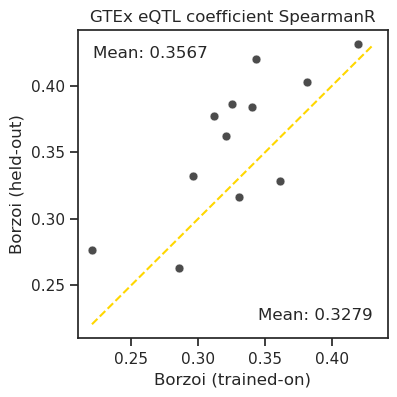

In [8]:
#Plot eQTL coefficient correlations (trained-on vs held-out)

plt.figure(figsize=(4,4))
plt.title('GTEx eQTL coefficient SpearmanR')
sns.scatterplot(x=metrics_borzoi_df_train.spearmanr.values,
                y=metrics_borzoi_df_test.spearmanr.values,
                color='black', alpha=0.7, s=40)
ax = plt.gca()

ax.text(0.95, 0.05, 'Mean: %.4f' % metrics_borzoi_df_train.spearmanr.mean(), 
                horizontalalignment='right', verticalalignment='bottom',
                transform=ax.transAxes)
ax.text(0.05, 0.95, 'Mean: %.4f' % metrics_borzoi_df_test.spearmanr.mean(), 
                horizontalalignment='left', verticalalignment='top',
                transform=ax.transAxes)

vmin = min(metrics_borzoi_df_train.spearmanr.min(), metrics_borzoi_df_test.spearmanr.min())
vmax = max(metrics_borzoi_df_train.spearmanr.max(), metrics_borzoi_df_test.spearmanr.max())
ax.plot([vmin,vmax], [vmin,vmax], linestyle='--', c='gold')

ax.set_xlabel('Borzoi (trained-on)')
ax.set_ylabel('Borzoi (held-out)')

plt.savefig('eqtl_coef_scatter_train_vs_test.pdf')


In [11]:
#Print list of Spearman correlation metrics (train)
metrics_borzoi_df_train


,tissue,method,spearmanr
0,Adipose_Subcutaneous,Borzoi (trained-on loci),0.330841
2,Breast_Mammary_Tissue,Borzoi (trained-on loci),0.339893
4,Colon_Transverse,Borzoi (trained-on loci),0.324959
6,Esophagus_Mucosa,Borzoi (trained-on loci),0.320422
8,Lung,Borzoi (trained-on loci),0.361207
10,Muscle_Skeletal,Borzoi (trained-on loci),0.285382
12,Pancreas,Borzoi (trained-on loci),0.342854
14,Skin_Not_Sun_Exposed_Suprapubic,Borzoi (trained-on loci),0.311632
16,Spleen,Borzoi (trained-on loci),0.381288
18,Testis,Borzoi (trained-on loci),0.220554


In [12]:
#Print list of Spearman correlation metrics (test)
metrics_borzoi_df_test


,tissue,method,spearmanr
1,Adipose_Subcutaneous,Borzoi (held-out loci),0.316002
3,Breast_Mammary_Tissue,Borzoi (held-out loci),0.384076
5,Colon_Transverse,Borzoi (held-out loci),0.386624
7,Esophagus_Mucosa,Borzoi (held-out loci),0.362608
9,Lung,Borzoi (held-out loci),0.328478
11,Muscle_Skeletal,Borzoi (held-out loci),0.262530
13,Pancreas,Borzoi (held-out loci),0.420025
15,Skin_Not_Sun_Exposed_Suprapubic,Borzoi (held-out loci),0.377455
17,Spleen,Borzoi (held-out loci),0.402704
19,Testis,Borzoi (held-out loci),0.276119
